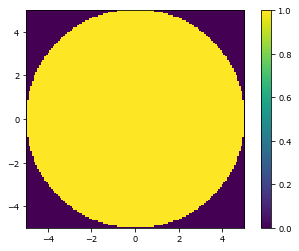

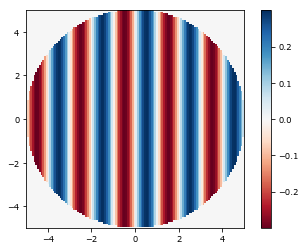

In [1]:
from hcipy import *
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

N = 128
padding = 1 # zero-padding on pyramid output. 1 means sub-pupil images touch the outside edges

D_keck = 9.96
keck_aperture = circular_aperture(D_keck) 
# I also implemented a better make_keck_aperture, this is just for simplicity when testing
pupil_grid = make_pupil_grid(N, D_keck * padding)

wf = Wavefront(keck_aperture(pupil_grid))

aberrated = wf.copy()
amplitude = 0.3
spatial_frequency = 5
aberrated.electric_field *= np.exp(1j * amplitude * np.sin(2*np.pi * pupil_grid.x / D_keck * spatial_frequency))

imshow_field(wf.intensity)
plt.colorbar()
plt.show()

imshow_field(aberrated.phase, cmap='RdBu')
plt.colorbar()
plt.show()

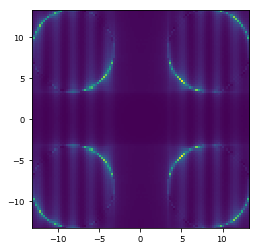

In [25]:
sps = 40 #sub-pupil size
pupsep = 65/39.3
outgrid_size = int(np.ceil(sps * (pupsep + 1)))
keck_pyramid = PyramidWavefrontSensorOptics(pupil_grid, pupil_separation=pupsep, num_pupil_pixels=sps)
pyramid_grid = make_pupil_grid(N, 3.6e-3)
pyramid_output = keck_pyramid.forward(aberrated).intensity
imshow_field(pyramid_output)
plt.show()

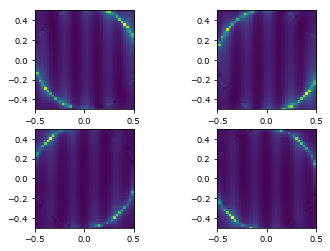

In [26]:
outgrid = np.zeros((N, N)).tolist()
pyramid_output.shape = (outgrid_size, outgrid_size)
buffer = (N - outgrid_size)//2
# added ability to get sub-pupil images that are separated. Default PWFSOptics has pupil separation = 1.5 but 
# image extraction assumes separation = 1. Not sure, but this may have caused errors before.
for rownum, row in enumerate(pyramid_output.tolist()):
    for colnum, el in enumerate(row):
        outgrid[rownum+buffer][colnum+buffer] = el
images = Field(np.asarray(outgrid).ravel(), pyramid_grid)
image = images.shaped
sub_images = [image[buffer:sps+buffer, buffer:sps+buffer], 
              image[(N-buffer-sps-1):(N-buffer-1), buffer:sps+buffer],
              image[buffer:sps+buffer, (N-buffer-sps-1):(N-buffer-1)], 
              image[(N-b1uffer-sps-1):(N-buffer-1), (N-buffer-sps-1):(N-buffer-1)]]
subimage_grid = make_pupil_grid(sps)
for count, img in enumerate(sub_images):
    img = img.ravel()
    img.grid = subimage_grid
    sub_images[count] = img
    plt.subplot(2,2,count+1)
    imshow_field(img)
# This slightly crops some of the edges of the sub-pupil images, but it is the actual size we'll have to work with.
# Hopefully no significant information loss because of this. (Maybe off by one?)

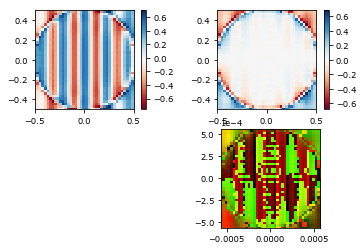

In [27]:
def estimate(EstimatorObject, images_list):
    '''
    Slightly edited version of the PWFSEstimator.estimate function. The earlier function had a difference in sub-pupil
    numbering compared to the literature I found. As implemented before, it was 
    a b
    c d
    but according to papers such as https://ui.adsabs.harvard.edu/#abs/2006OExpr..1411925B/abstract (page 3) it's
    b a
    c d
    '''
    I_b = images_list[0]
    I_a = images_list[1]
    I_c = images_list[2]
    I_d = images_list[3]
    norm = I_a + I_b + I_c + I_d
    I_x = (I_a + I_b - I_c - I_d) / norm
    I_y = (I_a - I_b - I_c + I_d) / norm
    dummy = Field(np.zeros(I_x.size), I_x.grid)
    I_x = I_x.ravel()
    I_y = I_y.ravel()
    dummy = dummy.ravel()
    res = Field([I_x, I_y, dummy], EstimatorObject.pupil_mask.grid)
    # previously, was not possible to plot res, can now do so as a red-green plot (red = x and green = y).
    return res, I_x, I_y

pyramid_subgrid = make_pupil_grid(sps*2, (3.6e-3)*sps*2/N)
keck_pyramid_estimator = PyramidWavefrontSensorEstimator(keck_aperture, pyramid_subgrid)
aberratedslopes, x_slopes, y_slopes = estimate(keck_pyramid_estimator, sub_images)
plt.subplot(2,2,1)
imshow_field(x_slopes, cmap='RdBu')#, vmax=0.005, vmin=-0.005) # estimate output is quite small, can't see differences easily
plt.colorbar()
plt.subplot(2,2,2)
imshow_field(y_slopes, cmap='RdBu')#, vmax=0.005, vmin=-0.005)
plt.colorbar()
plt.subplot(2,2,4)
imshow_field(aberratedslopes, vmax=0.005, vmin=-0.005)
plt.show()
